In [1]:
########### loading packages
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import gensim
from stop_words import get_stop_words
from nltk.tokenize import PunktSentenceTokenizer
from gensim.models import CoherenceModel
from gensim.utils import simple_preprocess
from gensim.models import TfidfModel
from wordcloud import WordCloud
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline
from gensim import corpora, models, similarities 
import spacy
import itertools
import pyLDAvis
import pyLDAvis.gensim 
pyLDAvis.enable_notebook()
import warnings
warnings.filterwarnings("ignore")
from nltk.stem.snowball import SnowballStemmer
stemmer = SnowballStemmer("english")
import pickle

In [2]:
## LOAD
d_cal = gensim.corpora.Dictionary.load('dictionary_1804_filter80.dict')
c_cal = gensim.corpora.MmCorpus('corpus_1804_filter80.mm')

In [3]:
m_cal = gensim.models.ldamodel.LdaModel.load('model_1804_filter80.model')

In [4]:
with open("data_lemmetized.txt",'rb')as f:
    texts = pickle.load(f)
    f.close()

In [5]:
#create a Gensim dictionary from the texts
%time dictionary= corpora.Dictionary(texts)
#remove extremes (similar to the min/max df step used when creating the tf-idf matrix)
%time dictionary.filter_extremes(no_below=10, no_above=0.3)

CPU times: user 4.57 s, sys: 576 ms, total: 5.15 s
Wall time: 5.27 s
CPU times: user 158 ms, sys: 12.8 ms, total: 171 ms
Wall time: 172 ms


In [6]:
#convert the dictionary to a bag of words corpus for reference
%time corpus = [dictionary.doc2bow(text) for text in texts]

CPU times: user 3.14 s, sys: 91.3 ms, total: 3.24 s
Wall time: 3.28 s


In [7]:
####### LDA model
%time ldamodel = models.LdaModel(corpus, num_topics=10, \
                                   id2word=dictionary, update_every=5,\
                                 chunksize=10000,  passes=20)

CPU times: user 7min 48s, sys: 30.9 s, total: 8min 19s
Wall time: 8min 9s


In [8]:
# Get the topic related words 
topics_matrix = ldamodel.show_topics(formatted=False, num_words=10, num_topics=10)
topics_matrix = np.array(topics_matrix, dtype=object)
topic_words = topics_matrix[:,1]

In [9]:
allls = []
for k in range(len(topic_words)):
    wordls = []
    for i, v in topic_words[k]:
        wordls.append(i)
    print(wordls)
    allls.append(wordls)

['desist', 'ceas', 'new', 'california', 'first', 'trust', 'illinoi', 'march', 'cea', 'texa']
['report', 'review', 'asset', 'capit', 'includ', 'manag', 'credit', 'polici', 'region', 'implement']
['breach', 'fiduciari', 'enumer', 'person', 'transfer', 'organ', 'attempt', 'demonstr', 'serv', 'intent']
['review', 'modif', 'region', 'manag', 'commission', 'capit', 'polici', 'report', 'asset', 'oper']
['complianc', 'report', 'review', 'program', 'includ', 'ensur', 'bsa', 'implement', 'polici', 'manag']
['asset', 'report', 'oper', 'region', 'capit', 'polici', 'manag', 'credit', 'review', 'classifi']
['credit', 'compani', 'exten', 'capit', 'thrift', 'liabil', 'transact', 'control', 'hold', 'condit']
['capit', 'correct', 'region', 'prompt', 'condit', 'total', 'asset', 'period', 'materi', 'supervisori']
['credit', 'alj', 'fact', 'request', 'examin', 'also', 'counsel', 'record', 'evid', 'inform']
['penalti', 'money', 'civil', 'flood', 'agre', 'fail', 'fact', 'conclus', 'treasuri_unit', 'locat']


In [10]:
dataprepared = pyLDAvis.gensim.prepare(ldamodel, corpus, dictionary)
pyLDAvis.display(dataprepared)

In [5]:
t_cal = texts

In [6]:
def compute_optimal_tp_num(dictionary, corpus, texts, limit, start=2, step=5):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus s
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    parameter_list = list(range(0, limit, 5))
    parameter_list[0] = start
    grid ={}
    for num_topics in parameter_list:
        print(num_topics)

        %time model = models.LdaModel(corpus, num_topics=num_topics,\
                                id2word=dictionary, \
                                      update_every=5, chunksize=10000,  passes=20)
        model_list.append(model)
        %time perplex = model.log_perplexity(corpus, total_docs=len(corpus))
        grid[num_topics]=[]
        grid[num_topics].append(perplex)
        %time coherencemodel = CoherenceModel(model=model, texts=texts,\
                                              dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values, grid

In [ ]:
#%time model_list_rev, coherence_values_rev, grid_rev = compute_optimal_tp_num(dictionary=d_cal,\
#                                                                            corpus=c_cal,\
#                                                        texts=texts, start=2, limit=100, step=5)

In [7]:
corpus = c_cal
dictionary = d_cal
texts = t_cal
limit = 50
start = 2

coherence_values = []
model_list = []
parameter_list = list(range(0, limit, 5))
parameter_list[0] = start
grid ={}
for num_topics in parameter_list:
    print(num_topics)
    %time model = models.LdaModel(corpus, num_topics=num_topics,\
                            id2word=dictionary, \
                                  update_every=5, chunksize=10000,  passes=20)
    model_list.append(model)
    print('pp')
    %time perplex = model.log_perplexity(corpus, total_docs=len(corpus))
    grid[num_topics]=[]
    grid[num_topics].append(perplex)
    print('cv')
    %time coherencemodel = CoherenceModel(model=model, texts=texts,\
                                          dictionary=dictionary, coherence='c_v')
    coherence_values.append(coherencemodel.get_coherence())

2
CPU times: user 9min 21s, sys: 41 s, total: 10min 2s
Wall time: 10min 10s
pp
CPU times: user 21.2 s, sys: 1.11 s, total: 22.3 s
Wall time: 24.4 s
cv
CPU times: user 1.14 ms, sys: 1.12 ms, total: 2.26 ms
Wall time: 2.08 ms
5
CPU times: user 9min 54s, sys: 43.7 s, total: 10min 38s
Wall time: 10min 37s
pp
CPU times: user 20.7 s, sys: 1.07 s, total: 21.8 s
Wall time: 21.7 s
cv
CPU times: user 1.67 ms, sys: 1.16 ms, total: 2.82 ms
Wall time: 2.75 ms
10
CPU times: user 9min 45s, sys: 46.8 s, total: 10min 31s
Wall time: 10min 25s
pp
CPU times: user 19.5 s, sys: 1.01 s, total: 20.6 s
Wall time: 20.1 s
cv
CPU times: user 2.27 ms, sys: 1.19 ms, total: 3.46 ms
Wall time: 3.47 ms
15
CPU times: user 10min 13s, sys: 48.9 s, total: 11min 2s
Wall time: 11min
pp
CPU times: user 21.6 s, sys: 1.24 s, total: 22.8 s
Wall time: 22.5 s
cv
CPU times: user 3.46 ms, sys: 1.2 ms, total: 4.65 ms
Wall time: 4.78 ms
20
CPU times: user 10min 23s, sys: 45.1 s, total: 11min 8s
Wall time: 10min 54s
pp
CPU times: user

In [40]:
#print(num_topics)
num_topics = 50
%time model = models.LdaModel(corpus, num_topics=num_topics,\
                        id2word=dictionary, \
                              update_every=5, chunksize=10000,  passes=20)
model_list.append(model)
print('pp')
%time perplex = model.log_perplexity(corpus, total_docs=len(corpus))
grid[num_topics]=[]
grid[num_topics].append(perplex)
print('cv')
%time coherencemodel = CoherenceModel(model=model, texts=texts,\
                                      dictionary=dictionary, coherence='c_v')
coherence_values.append(coherencemodel.get_coherence())

CPU times: user 13min 25s, sys: 1min, total: 14min 26s
Wall time: 13min 59s
pp
CPU times: user 29.2 s, sys: 1.47 s, total: 30.7 s
Wall time: 29 s
cv
CPU times: user 8.94 ms, sys: 5.62 ms, total: 14.6 ms
Wall time: 19 ms


In [43]:
parameter_list.append(50)

In [55]:
cv_dic = {}
for i,v in enumerate(parameter_list):
    cv_dic[v] = [coherence_values[i]]

In [73]:
cv_dic

{2: [0.5309068371389403],
 5: [0.4526138268982522],
 10: [0.4687848727347266],
 15: [0.44718482933510784],
 20: [0.45810221019496317],
 25: [0.46272689671577105],
 30: [0.45336169486418576],
 35: [0.4255223816633138],
 40: [0.4364226047049361],
 45: [0.43242416952536433],
 50: [0.41037927005743086]}

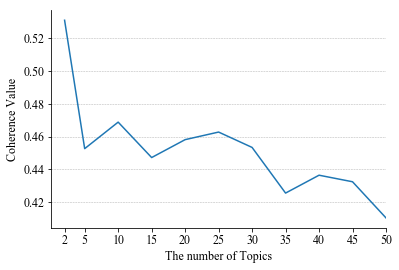

In [74]:
# Show CV
#x = range(start, limit, step)
dfcv = pd.DataFrame(cv_dic)
axcv = plt.figure(figsize=(6,4)).add_subplot(111)
dfcv.iloc[0].transpose().plot(ax=axcv, fontsize = 12)
plt.xlim(0, parameter_list[-1])
#axcv.spines['left'].set_visible(False)
axcv.spines['right'].set_visible(False)
axcv.spines['top'].set_visible(False)
plt.ylabel('Coherence Value',fontsize = 12)                                              
plt.xlabel('The number of Topics',fontsize = 12)
#plt.legend((""), loc='best')
#axcv.set_xlim(xmin=0)
plt.xticks(parameter_list)
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#plt.show() 
plt.savefig('cv.png',dpi=300,facecolor='w', bbox_inches = 'tight')

In [9]:
cv={}
for i,v in enumerate(parameter_list):
    cv[v] =coherence_values[i] 
cv   

{2: 0.5309068371389403,
 5: 0.4526138268982522,
 10: 0.4687848727347266,
 15: 0.44718482933510784,
 20: 0.45810221019496317,
 25: 0.46272689671577105,
 30: 0.45336169486418576,
 35: 0.4255223816633138,
 40: 0.4364226047049361,
 45: 0.43242416952536433}

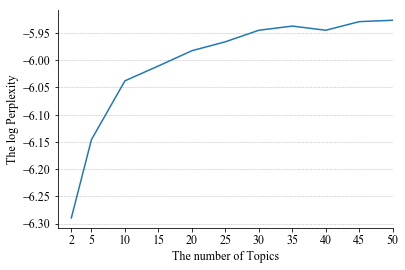

In [72]:
# perplexity
dfp = pd.DataFrame(grid)
ax = plt.figure(figsize=(6,4)).add_subplot(111)
dfp.iloc[0].transpose().plot(ax=ax, fontsize = 12)
plt.xlim(0, parameter_list[-1])
#ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
plt.ylabel('The log Perplexity',fontsize = 12)                                              
plt.xlabel('The number of Topics',fontsize = 12)
#ax.set_xlim(xmin=0)
plt.xticks(parameter_list)
#plt.legend((""), loc='best')
plt.grid(True, 'major', 'y', ls='--', lw=.5, c='k', alpha=.3)
#plt.show() 
plt.savefig('peplexity.png',dpi=300,facecolor='w',bbox_inches = 'tight')

In [75]:
grid

{2: [-6.289547648971698],
 5: [-6.1458808870794135],
 10: [-6.037776514021664],
 15: [-6.0104823478896625],
 20: [-5.982494937651639],
 25: [-5.966064012900598],
 30: [-5.944889073274803],
 35: [-5.937219390286935],
 40: [-5.944835283574178],
 45: [-5.9290729774427025],
 50: [-5.926489988225414]}

In [11]:
grid

{2: [-6.289547648971698],
 5: [-6.1458808870794135],
 10: [-6.037776514021664],
 15: [-6.0104823478896625],
 20: [-5.982494937651639],
 25: [-5.966064012900598],
 30: [-5.944889073274803],
 35: [-5.937219390286935],
 40: [-5.944835283574178],
 45: [-5.9290729774427025]}

In [13]:
for i, v in grid.items():
    #print(i,v)
    print(i, np.exp2(-v[0]))

2 78.22444697680159
35 61.274690643468475
20 63.22814275205461
5 70.80998408705945
40 61.59901102999511
25 62.51211947739241
10 65.6979529548787
45 60.92966813884474
30 61.60130774138423
15 64.46670527537523
